In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

import os
from torchsummary import summary

import pandas as pd
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize(512)])

train_path = '~/Bureau/zentout/dataset/screw_mvtec/train'
trainset = torchvision.datasets.ImageFolder(train_path, transform = transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle = True)

test_path = '~/Bureau/zentout/dataset/screw_mvtec/test'
testset = torchvision.datasets.ImageFolder(test_path, transform = transform)
testloader = DataLoader(testset, batch_size=1, shuffle = False)

torch.Size([3, 512, 512])


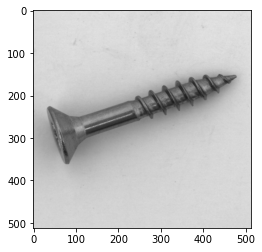

In [3]:
image = trainset[1][0]
imshow(image.permute(1,2,0))
print(image.size())

In [15]:
class VAE(nn.Module):
    def __init__(self,enc_out_dim=512, latent_dim=128, input_height=512):
        super(VAE, self).__init__()
        
        
        #encoder and decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )
        
        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def loss_elbo(self, x, x_hat, z, mu, std):
        kl = self.kl_divergence(z, mu, std)
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        elbo = (kl - recon_loss)
        return elbo.mean()
    
    def reparametrize(self,mu,log_var):
        #Reparametrization Trick to allow gradients to backpropagate from the 
        #stochastic part of the model
        sigma = torch.exp(0.5*log_var)
        z = torch.distributions.Normal(torch.zeros_like(mu),1).rsample()
        
        return mu + sigma*z
        
    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        std = torch.exp(log_var / 2)
        
        z_N = torch.distributions.Normal(torch.zeros_like(mu),1).rsample()
        z = self.reparametrize(mu,log_var)
        
        x_hat = self.decoder(z)
        
        elbo = self.loss_elbo(x, x_hat, z, mu, std)
        
        return x_hat, elbo

        

In [16]:
vae = VAE().to('cuda')
opt = torch.optim.Adam(vae.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [17]:
summary(vae, (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,728
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
         MaxPool2d-4         [-1, 64, 512, 512]               0
            Conv2d-5         [-1, 64, 512, 512]          36,864
       BatchNorm2d-6         [-1, 64, 512, 512]             128
              ReLU-7         [-1, 64, 512, 512]               0
            Conv2d-8         [-1, 64, 512, 512]          36,864
       BatchNorm2d-9         [-1, 64, 512, 512]             128
             ReLU-10         [-1, 64, 512, 512]               0
     EncoderBlock-11         [-1, 64, 512, 512]               0
           Conv2d-12         [-1, 64, 512, 512]          36,864
      BatchNorm2d-13         [-1, 64, 512, 512]             128
             ReLU-14         [-1, 64, 5

In [18]:
classes = ['abnormal','good']

In [19]:
def train(model,opt, trainloader, testloader, epochs):
    losses = []
    i = 0
    for epoch in range(epochs):
        print("starting training")
        step_loss = 0
        
        for images, labels in trainloader:
            out, loss = model(images.to('cuda'))
            
            opt.zero_grad()
            step_loss += loss.item()
            loss.backward()
            opt.step()
            
            losses.append(loss.item())
            
            if i%40 == 39:
                print(f'[Epoch : {epoch + 1}, step : {i}] loss : {step_loss/40}')
                step_loss = 0
            i+=1
        
        print(f'finished epoch {epoch +1}')
            
        if epoch%2 == 0:
            print('starting validation')
            val_losses = []
            def_losses = []
            ok_losses = []
            val_labels = []
            predictions = []
            model.eval()
            for val_image, label in testloader:
                val_out, elbo = model(val_image.to('cuda'))
                loss = loss_function(val_out,val_image.to('cuda'))
                val_losses.append(loss.item())
                val_labels.append(classes[label])
                
                if label.item() == 0:
                    def_losses.append(loss.item())
                else:
                    ok_losses.append(loss.item())
                
            ok_losses.sort()
            threshold = ok_losses[8*int(np.argmax(ok_losses)/10)]
            for l in val_losses:
                if l > threshold:
                    predictions.append(classes[0])
                else:
                    predictions.append(classes[1])
            
            # Save losses density image
            save_validation_losses_density(epoch, val_losses, val_labels)
            save_confusion_matrix(epoch, val_labels, predictions)
            
            print(f'def_valid_loss : {sum(def_losses)/len(def_losses)} ')
            print(f'ok_valid_loss : {sum(ok_losses)/len(ok_losses)} ')
            
            
    return losses

In [20]:
def save_validation_losses_density(epoch, val_losses, val_labels):
    if not os.path.exists('screw_density_images'):
            os.makedirs('screw_density_images')
    df = pd.DataFrame(val_losses, columns=['loss'])
    df['labels'] = val_labels
    #df_def = pd.DataFrame(losses_def, columns=['loss_def'])
    sns.displot(df,x="loss" ,hue="labels", kind="kde")
    plt.savefig(f"screw_density_images/Density-epoch-{epoch+1}.png")

In [10]:
def save_confusion_matrix(epoch, labels, predictions):
    if not os.path.exists('screw_confusion_matrix_images'):
            os.makedirs('screw_confusion_matrix_images')
    matrix = confusion_matrix(labels, predictions, labels=classes)
    annot = [["00","01"],["10","11"]]
    for i in range(2):
        for j in range(2):
            percentage = matrix[i][j] / sum(matrix[i]) * 100
            annot[i][j] = f"{matrix[i][j]} ({percentage:.1f}%)"

    # Plot the confusion matrix with Seaborn
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()

    # annot=True to annotate cells, ftm='g' to disable scientific notation
    sns.heatmap(matrix, annot=annot, square=True, fmt="s", ax=ax)
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels([classes[0], classes[1]])
    ax.yaxis.set_ticklabels([classes[0], classes[1]])
    plt.savefig(f"screw_confusion_matrix_images/epoch-{epoch+1}.png")

starting training
[Epoch : 1, step : 39] loss : 751033.71875
[Epoch : 1, step : 79] loss : 685248.859375
finished epoch 1
starting validation
def_valid_loss : 0.015805181659137208 
ok_valid_loss : 0.0157921997739411 
starting training
[Epoch : 2, step : 119] loss : 653052.3453125
[Epoch : 2, step : 159] loss : 620844.48125
finished epoch 2
starting training
[Epoch : 3, step : 199] loss : 589671.2359375
[Epoch : 3, step : 239] loss : 558411.05625
finished epoch 3
starting validation
def_valid_loss : 0.015151298818333695 
ok_valid_loss : 0.01699505485139969 
starting training
[Epoch : 4, step : 279] loss : 527366.3359375
[Epoch : 4, step : 319] loss : 496808.39375
finished epoch 4
starting training
[Epoch : 5, step : 359] loss : 466245.63125
[Epoch : 5, step : 399] loss : 435573.78359375
finished epoch 5
starting validation
def_valid_loss : 0.014711488950221488 
ok_valid_loss : 0.014095487413791621 
starting training
[Epoch : 6, step : 439] loss : 405098.0609375
[Epoch : 6, step : 479] l

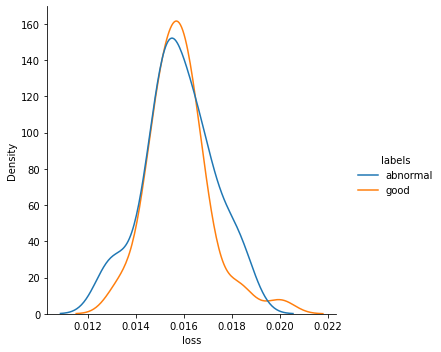

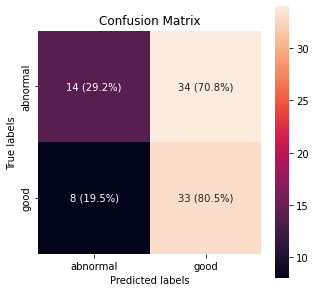

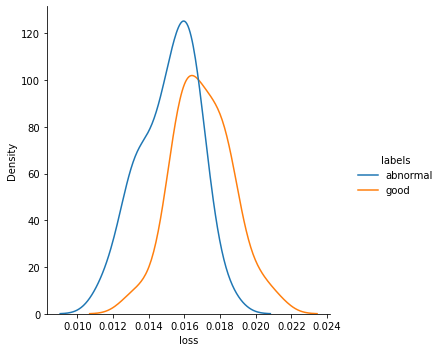

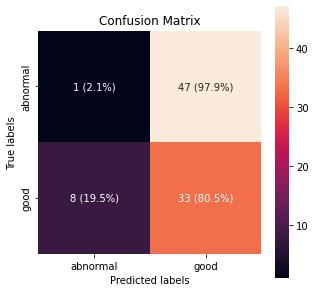

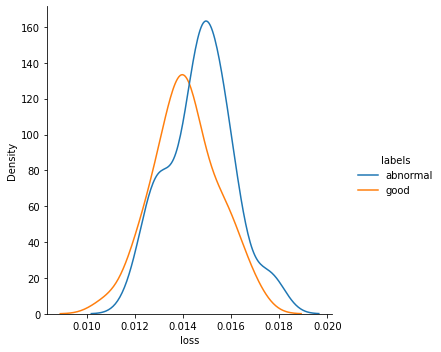

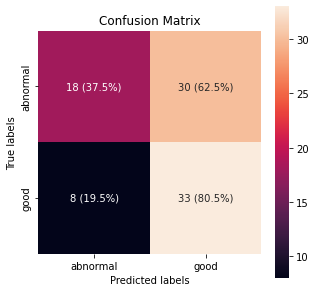

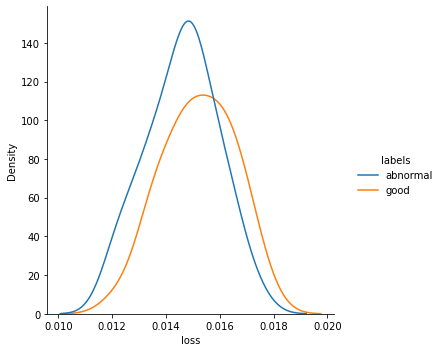

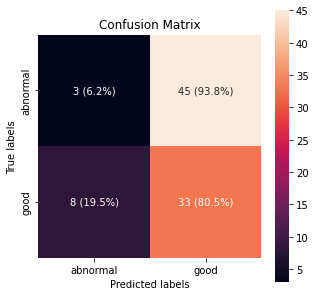

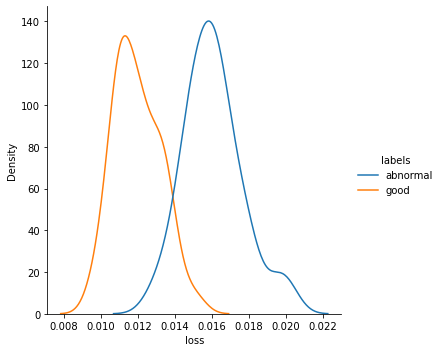

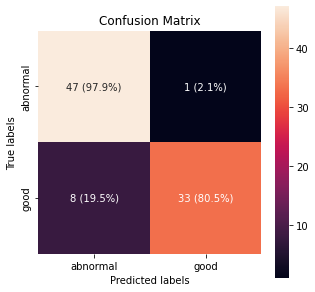

In [21]:
losses = train(vae, opt, trainloader,testloader, 10)

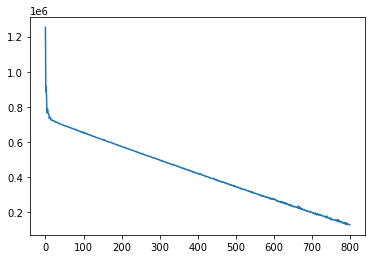

In [22]:
plt.plot(losses)

torch.Size([4, 3, 512, 512])


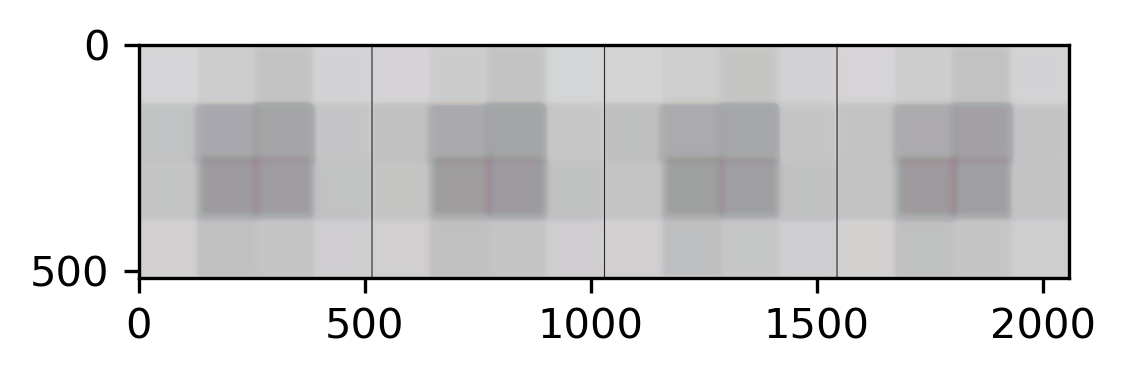

In [26]:


plt.figure(figsize=(4, 3), dpi=300)
exemple = iter(trainloader)
images, labels = next(exemple)
with torch.no_grad():
    encoded = vae.encoder(images.to('cuda'))
    mu = vae.fc_mu(encoded)
    log_var = vae.fc_var(encoded)
    std = torch.exp(log_var/2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    pred = vae.decoder(z)
        
print(pred.size())
# UNDO DATA NORMALIZATION
#normalize = cifar10_normalization()
#mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred.cpu()).permute(1, 2, 0).numpy() 
# PLOT IMAGES
plt.imshow(img)
plt.show()

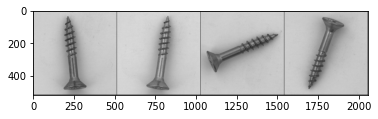

In [14]:
img = make_grid(images.cpu()).permute(1, 2, 0).numpy() 
# PLOT IMAGES
plt.imshow(img)
plt.show()